Check weak-lensing signal in simulations from particle data. Modified from Alexie's code (`calds_secretplot.py`)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)

import h5py
from astropy.io import ascii
from halotools.mock_observables import return_xyz_formatted_array, delta_sigma

# #---------------------------------------------------------------------------#
# #User imports
# import sys
# sys.path.append('/Users/fardila/Documents/GitHub/HSC_vs_hydro/')
# from functions import *

## box size 

In [2]:
# Massive black 2: Lbox = 100 h^-1 Mpc
# TNG100: Lbox = 75 h^-1 Mpc

Lbox = 75.0   # 75/h
period = np.array([Lbox,Lbox,Lbox])

# This is in Mpc/h comoving
rp_bins = np.logspace(-1.2,1.2,20) #error if using 1.5 because Lbox is 75 and not 100
print rp_bins

[ 0.06309573  0.08439482  0.11288379  0.15098972  0.20195898  0.27013381
  0.36132228  0.48329302  0.64643716  0.8646535   1.15653264  1.54694077
  2.06913808  2.76761237  3.70186906  4.95150067  6.62296762  8.8586679
 11.84906851 15.84893192]


## particle positions

In [3]:
particle_data_file = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/particles/boxptl_tng100-2_099.hdf5'

In [4]:
f = h5py.File(particle_data_file, 'r')

dm_coords = np.array(f['ptldm_Coordinates'])
dm_particle_mass = np.array(f['config'].attrs['dm_ptl_mass'])

gas_coords = np.array(f['ptlgas_Coordinates'])
gas_particle_masses = np.array(f['ptlgas_Masses'])

star_coords = np.array(f['ptlstr_Coordinates'])
star_particle_masses = np.array(f['ptlstr_Masses'])

z = f['config'].attrs['snap_z']
n_downsampled_particles = f['config'].attrs['ptlgas_nmax']
f.close()

print "Redshift: ", z
print n_downsampled_particles, ' particles'


Redshift:  0.0
20000000  particles


In [5]:
max(dm_coords[:,0]) ##kpc?

74999.99887498413

In [6]:
def format_coordinates_for_halotools(coords):
    # These are in units of kpc???, put into Mpc
    x=coords[:,0]/1000.0
    y=coords[:,1]/1000.0
    z=coords[:,2]/1000.0
    
    pos = return_xyz_formatted_array(x, y, z)
    
    return pos

dmpos = format_coordinates_for_halotools(dm_coords)
gaspos = format_coordinates_for_halotools(gas_coords)
starpos = format_coordinates_for_halotools(star_coords)

In [7]:
#check mass units
#check position units
#check number of particles for each species

### number of particles 

In [8]:
#illustris-1: 1820^3 DM particles
#illustris-2: 910^3 DM particles

n_total_particles_dm, n_total_particles_gas, n_total_particles_stars = 910**3, 910**3, 910**3

dm_downsampling_factor = n_total_particles_dm/n_downsampled_particles
gas_downsampling_factor = n_total_particles_gas/n_downsampled_particles
star_downsampling_factor = n_total_particles_stars/n_downsampled_particles

## galaxy positions 

In [9]:
# Read in the Galaxy File
tng_highres_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/galaxies_stellarmaps_tng75_11.2_highres.hdf5'
f = h5py.File(tng_highres_file, 'r')
gal_coords = np.array(f['catsh_SubhaloPos'])
f.close()

galpos = format_coordinates_for_halotools(gal_coords)


## weak lensing

In [10]:
output_files_location = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/particles/'

In [20]:
def weak_lensing(galpos, dmpos, gaspos, starpos, dm_particle_mass, dm_downsampling_factor, rp_bins, Lbox,
                 output_files_location, l_mass, u_mass):
    
    #calculate delta sigma for each component
    r, dm_ds = delta_sigma(galpos, dmpos, dm_particle_mass, dm_downsampling_factor, rp_bins, Lbox)
    dm_ds = dm_ds/1e12
    dm_array = np.array(zip(r,dm_ds), dtype=[('r(Mpc)','f8'),('DS','f8')])
    np.save(output_files_location+'dm_ds.npy', dm_array)
    print 'dm_ds'#, dm_ds

    r, gas_ds = delta_sigma(galpos, gaspos, gas_particle_masses, gas_downsampling_factor, rp_bins, Lbox)
    gas_ds = gas_ds/1e12
    gas_array = np.array(zip(r,gas_ds), dtype=[('r(Mpc)','f8'),('DS','f8')])
    np.save(output_files_location+'gas_ds.npy', gas_array)
    print 'gas_ds'#, gas_ds

    r, stars_ds = delta_sigma(galpos, starpos, star_particle_masses, star_downsampling_factor, rp_bins, Lbox)
    stars_ds = stars_ds/1e12
    stars_array = np.array(zip(r,stars_ds), dtype=[('r(Mpc)','f8'),('DS','f8')])
    np.save(output_files_location+'stars_ds.npy', stars_array)
    print 'stars_ds'#, stars_ds
    
    #sum all components together
    total_ds = (10**dm_ds)+(10**gas_ds)+(10**stars_ds)
    total_ds_array = np.array(zip(r,total_ds), dtype=[('r(Mpc)','f8'),('DS','f8')])
    np.save(output_files_location+'total_ds.npy', total_ds_array)
    print 'total_ds'#, total_ds
    
    #make plot
    
    fig = plt.figure(figsize=(15, 10))
    ax1 = plt.subplot()

    plt.loglog(r, 10**dm_ds, linestyle='--', linewidth=4.0, c='k', alpha=1, zorder=8, label='DM')
    plt.loglog(r, 10**gas_ds, linestyle='-.', linewidth=4.0, c='b', alpha=1, zorder=8, label='Gas')
    plt.loglog(r, 10**stars_ds, linestyle=':', linewidth=4.0, c='r', alpha=1, zorder=8, label='Stars')

    #plot total
    plt.loglog(r, total_ds, linestyle='-', linewidth=5.0, c='g', alpha=1, zorder=8, label='Total')

    ######################################################################################################################
    # plot details
    ######################################################################################################################
    # # X-Y limits
    # ax1.set_xlim(0.9, 4.5)
    # ax1.set_ylim(4, 11)

    ax1.tick_params(axis='both', which='major', labelsize=30)

    #text label
    ax1.text(0.5, 0.1, r'${0}<\mathrm{{M_{{halo}}}}<{1}$'.format(round(l_mass,2), round(u_mass,2)), size=30,
             transform=ax1.transAxes) #transform to axis coords rather than data coordinates

    ax1.legend(fontsize=20)

    #axis labels and vertical lines
    ax1.set_xlabel(r'$\mathrm{R \ [Mpc]}$', fontsize=30)
    ax1.set_ylabel(r'$\Delta\Sigma \ [(M_{\odot})/\mathrm{pc}^2]$', fontsize=30)
    # ax1.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6)
    # ax1.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')

    ######################################################################################################################

    # fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/surface_brightness_Illustris_matched_n.pdf',
    #             dpi=100, format='pdf', bbox_inches='tight')

    plt.show()

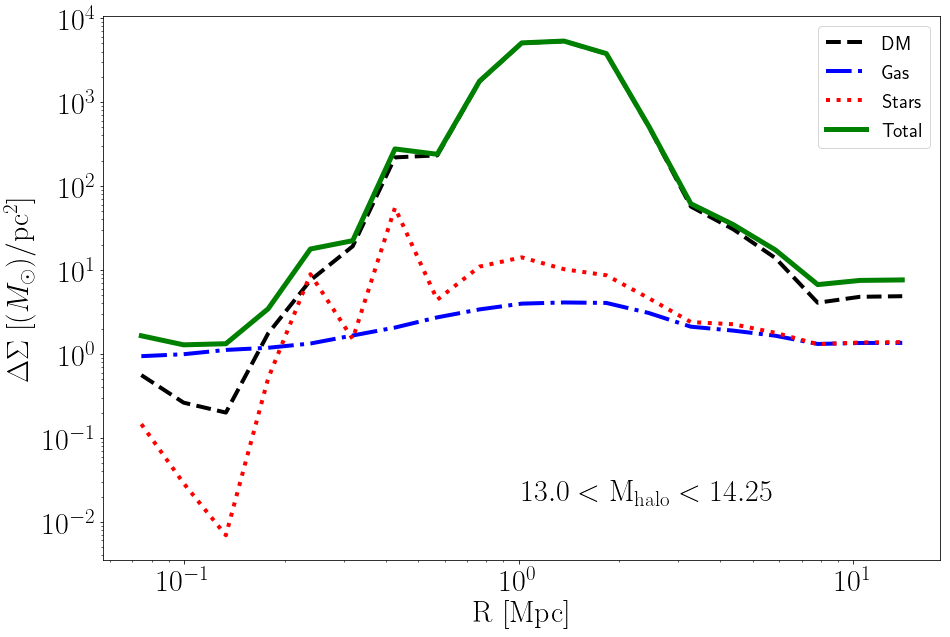

In [19]:
weak_lensing(galpos, dmpos, gaspos, starpos, dm_particle_mass, dm_downsampling_factor, rp_bins, Lbox,
                 output_files_location, 13.0, 14.25)

# Check bins of halo mass (same as plot)
the only thing changing are the galaxy positions


In [13]:
mass_bins = np.linspace(13.0,14.25,4)

In [14]:
f = h5py.File(tng_highres_file, 'r')
#cat_sh_mstar = np.array(f['catsh_SubhaloMassType'][:, 4])
tng_m_dm = np.log10(np.array(f['catgrp_Group_M_Crit200']))
gal_coords = np.array(f['catsh_SubhaloPos'])
f.close()

#stack masses and coordinates into single array
gal_array = np.stack((tng_m_dm, gal_coords[:,0],gal_coords[:,1],gal_coords[:,2]), axis=1)

In [15]:
def get_galaxies_in_bins(gal_array, mass_bins):
    '''
    gets galaxies in each mass bin of mass_bins. assumes mass is first column of gal_array
    '''
    n_bins = len(mass_bins) - 1
    
    gals_in_bins=[]
    
    masses = gal_array[:,0]
    
    for bin in range(n_bins):
        lower = mass_bins[bin]
        upper = mass_bins[bin+1]
        
        gals = gal_array[(masses>lower) & (masses<upper)]
        
        gals_in_bins.append(gals)
        
    return gals_in_bins

In [16]:
galaxies_in_bin = get_galaxies_in_bins(gal_array, mass_bins)

74  galaxies
dm_ds
gas_ds
stars_ds
total_ds


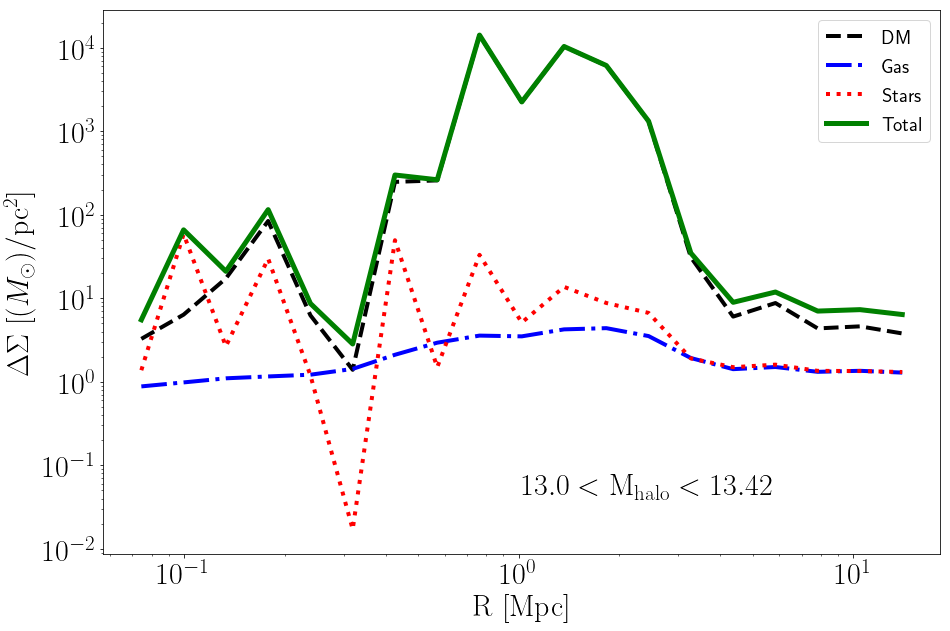

32  galaxies
dm_ds
gas_ds
stars_ds
total_ds


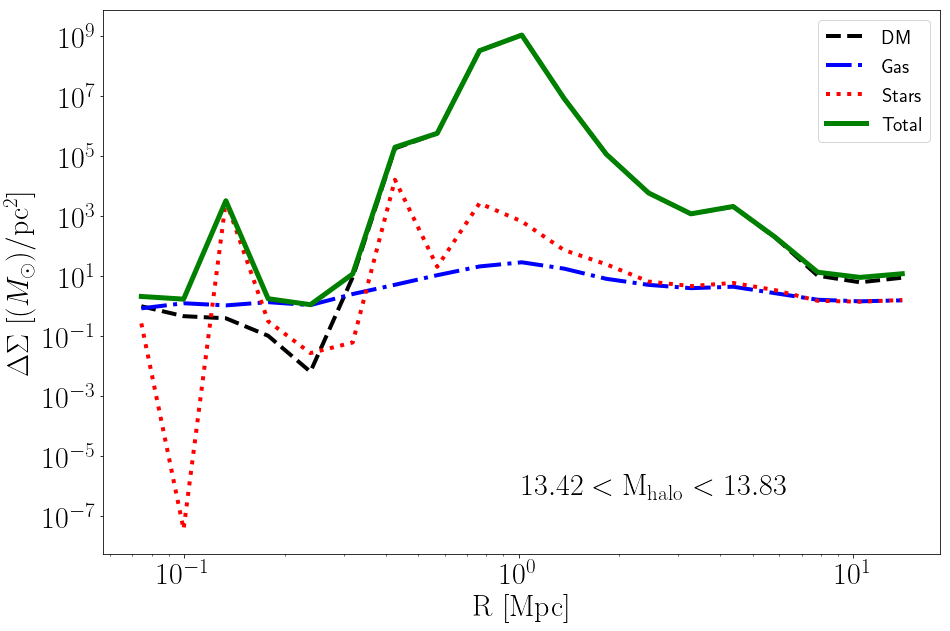

12  galaxies
dm_ds
gas_ds
stars_ds
total_ds


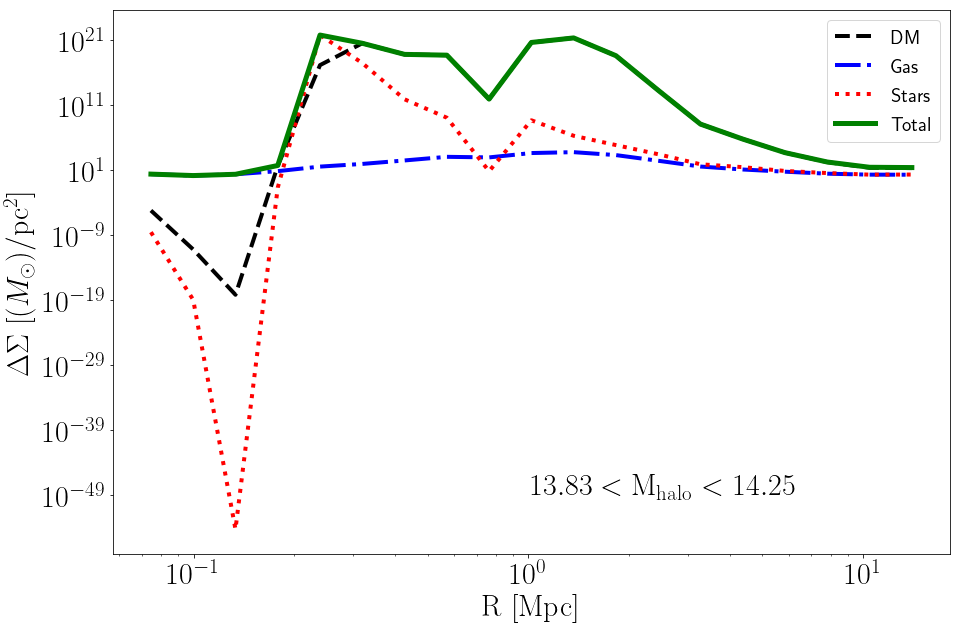

In [21]:
for i, gals in enumerate(galaxies_in_bin):
    
    gal_coords = gals[:,1:]
    galpos = format_coordinates_for_halotools(gal_coords)
    
    print len(galpos), ' galaxies'
    
    weak_lensing(galpos, dmpos, gaspos, starpos, dm_particle_mass, dm_downsampling_factor, rp_bins, Lbox,
                 output_files_location, mass_bins[i], mass_bins[i+1])

## compare to HSC